## **Fault prediction and classification for the Tennessee Eastman Process (TEP)**

This Jupyter notebook presents a comprehensive exploration of machine learning models aimed at predicting and classifying faults within the Tennessee Eastman Process. The Tennessee Eastman Process is a widely studied chemical process, and fault prediction and classification are critical tasks for ensuring its smooth operation and safety.

The notebook includes:
- Data preprocessing and feature engineering to prepare the dataset for modeling.
- Implementation of machine learning algorithms: random forest for real time prediction and LSTM for classification.
- Evaluation of model performance using relevant metrics like accuracy, precision, recall, and F1-score.
- Fine-tuning of models through hyperparameter optimization to enhance predictive capabilities.
- Visualization of results and insights into the behavior of different models.

This notebook serves as a practical example for engineers, researchers, and practitioners interested in applying machine learning techniques to fault prediction and classification in complex industrial processes like the Tennessee Eastman Process.

The following dependencies must be installed and ran for the proper function of the code base:

In [85]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn tensorflow gdown joblib

In [1]:
import pandas as pd
import gdown
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Input
from keras.models import Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from collections import defaultdict

## Data importing and pre-processing

The relevant data files for the model can be obtained by running the code block below.

In [2]:
# Create a temporary directory to store downloaded files
temp_dir = 'temp_downloads'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# List of file URLs
file_urls = [
    'https://drive.google.com/file/d/1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA/view?usp=sharing',
    'https://drive.google.com/file/d/1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo/view?usp=sharing',
    'https://drive.google.com/file/d/1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly/view?usp=sharing',
    'https://drive.google.com/file/d/1x_2gXR0Cnf2AA72q6PUIIipl_XQQMihI/view?usp=sharing'
]

# List of output file names
output_files = [
    'faulty_training.csv',
    'faultfree_training.csv',
    'faulty_testing.csv',
    'faultfree_testing.csv'
]

# Reading each file directly into a DataFrame
dataframes = []
for url, output_file in zip(file_urls, output_files):
    # Downloading the file into the temporary directory
    url_parts = url.split('/')
    file_id = url_parts[-2].split('=')[-1]
    url_direct = f'https://drive.google.com/uc?id={file_id}'
    output_path = os.path.join(temp_dir, output_file)
    gdown.download(url_direct, output_path, quiet=False)

    # Reading the CSV file into a DataFrame
    df = pd.read_csv(output_path, on_bad_lines='skip')

    # Appending the DataFrame to the list
    dataframes.append(df)

# Unpacking the list of DataFrames
faulty_training, faultfree_training, faulty_testing, faultfree_testing = dataframes

# Clean up temporary directory
import shutil
shutil.rmtree(temp_dir)

'''
df = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Training.csv', on_bad_lines='skip')
df2 = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Training.csv', on_bad_lines='skip')
df_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Testing.csv', on_bad_lines='skip')
df2_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Testing.csv', on_bad_lines='skip')
'''

Downloading...
From (original): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA
From (redirected): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA&confirm=t&uuid=7dbd04de-6926-4826-994f-0d4cf10b2a63
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faulty_training.csv
100%|██████████| 1.87G/1.87G [00:49<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faultfree_training.csv
100%|██████████| 93.6M/93.6M [00:02<00:00, 37.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly
From (redirected): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly&confirm=t&uuid=58e532ca-1147-4c38-bb57-f692e469a579
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final

"\ndf = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_Faulty_Training.csv', on_bad_lines='skip')\ndf2 = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_FaultFree_Training.csv', on_bad_lines='skip')\ndf_test = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_Faulty_Testing.csv', on_bad_lines='skip')\ndf2_test = pd.read_csv(r'D:\\OneDrive - Alberta Innovates\\school\\machine learning - 788\x0cinal project\\TEP_FaultFree_Testing.csv', on_bad_lines='skip')\n"

In [3]:
f_train = faulty_training.copy()
ff_train = faultfree_training.copy()
f_test = faulty_testing.copy()
ff_test = faultfree_testing.copy()

As faults are introduced every **hour** for the faulty training data set, and every **8 hours** for the faulty testing data set, a faultOccurence variable is added, and the faultNumber labelling is corrected for mislabelled data for the first 20 and 160 points, respectively.

In [4]:
def add_and_set_fault_occurrence(df, num_first, num_last=None):
    '''
    Add and set the 'faultOccurrence' column for binary classification.

    Parameters:
    - df: DataFrame containing fault data.
    - num_first: Number of initial rows to label as non-faulty.
    - num_last: Number of final rows to label as faulty (default=None, all rows are labeled as non-faulty).

    Returns:
    - DataFrame with 'faultOccurrence' column added and values set for binary classification.
    '''
    
    # Check if 'faultOccurrence' column already exists
    if 'faultOccurrence' not in df.columns:
        # Inserting the 'faultOccurrence' column filled with NaN initially to the right of 'faultNumber'
        fault_number_index = df.columns.get_loc('faultNumber')
        df.insert(fault_number_index + 1, 'faultOccurrence', pd.NA)

    # Function to set values based on the condition
    def set_fault_occurrence(group):
        if num_last is not None:
            group.iloc[:num_first, df.columns.get_loc('faultOccurrence')] = 0
            group.iloc[-num_last:, df.columns.get_loc('faultOccurrence')] = 1
        else:
            group.iloc[:, df.columns.get_loc('faultOccurrence')] = 0
        return group

    # Applying the function to each group
    df = df.groupby(df.index // (num_first + (num_last or 0))).apply(set_fault_occurrence)
    df['faultOccurrence'] = df['faultOccurrence'].astype(int)
    df.reset_index(drop=True, inplace=True)

    return df

# Add the faultOccurence column for binary classification
f_train = add_and_set_fault_occurrence(f_train, 20, 480)
f_test = add_and_set_fault_occurrence(f_test, 160, 800)
ff_train = add_and_set_fault_occurrence(ff_train, len(ff_train))
ff_test = add_and_set_fault_occurrence(ff_test, len(ff_test))

# Set faultNumber to 0 for rows where faultOccurence is 0 (no fault)
f_train.loc[f_train['faultOccurrence'] == 0, 'faultNumber'] = 0
f_test.loc[f_test['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_train.loc[ff_train['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_test.loc[ff_test['faultOccurrence'] == 0, 'faultNumber'] = 0

As part of the data pre-processing stage, for binary classification (using Random Forest), a stitched data set for training is generated using statistical properties of the fault free data sets provided.

In [5]:
avg_training = faultfree_training.mean()
std_training = faultfree_training.std()
avg_testing = faultfree_testing.mean()
std_testing = faultfree_testing.std()

In [86]:
#Sub-sample (20)
f_train = f_train.loc[(f_train['simulationRun']<41),:]
ff_train = ff_train.loc[(ff_train['simulationRun']<41),:]

f_test = f_test.loc[(f_test['simulationRun']<41),:]
ff_test = ff_test.loc[(ff_test['simulationRun']<41),:]

#Combine Test data
#combined_df_test = pd.concat([f_test, ff_test], ignore_index=True)
combined_df_test = f_test

#Combine Training data
#combined_df = pd.concat([f_train, ff_train], ignore_index=True)
combined_df = f_train

The pipeline for the Random Forest model involves creating lag features with four different lags, as well as applying a Fourier transform. Features xmeas_2, xmeas_5, xmeas_12, xmeas_14, xmeas_15, xmeas_17, xmeas_37, xmv_7, xmv_8 are the targets of this feature engineering as per the initial EDA found elsewhere.

In [87]:
features_to_plot = ['xmeas_2','xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37','xmv_7', 'xmv_8']

def process_fault_run(mask, feature, window_size, j):
    new_columns = defaultdict(list)
    frequency_feat = [np.nan] * len(mask)

    for i in range(len(mask)):
        if i < window_size:
            frequency_feat[i] = np.nan
        else:
            frequency_feat[i] = np.abs(np.fft.fft(mask[i-window_size:i])[1:]).max()

    feature_ma = f'{feature}_MA'
    feature_std = f'{feature}_STD'
    new_columns[feature_ma].extend(mask.rolling(window=window_size, min_periods=1).mean())
    new_columns[feature_std].extend(mask.rolling(window=window_size, min_periods=1).std())

    for i in j:
        lag_name = f'{feature}_lag{i}'
        lag = mask.shift(i)
        new_columns[lag_name].extend(lag)

    feature_f = f'{feature}_frequency'
    new_columns[feature_f].extend(frequency_feat)

    return new_columns

def featureengg_parallel(combined_df, features_to_plot):
    clean_df = combined_df.drop(columns=features_to_plot).copy()
    window_size = 20  # Window size
    j = [2, 4, 6, 8]  # Lag intervals

    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(
        delayed(process_fault_run)(mask, feature, window_size, j)
        for fault in clean_df['faultNumber'].unique()
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique()
        for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample','faultOccurrence'])
        for mask in [clean_df[(clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)][feature]]
    )

    new_columns = defaultdict(list)
    for result in results:
        for key, value in result.items():
            new_columns[key].extend(value)

    new_columns_df = pd.DataFrame(new_columns)
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)
    return clean_df

In [88]:
#Feature engineering of Training Data
clean_df = featureengg_parallel(combined_df, features_to_plot)

#For Binary classification
clean_df_cleaned = clean_df.dropna(axis=0)
comb_x_df = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample','faultOccurrence'])
comb_y_df = clean_df_cleaned['faultOccurrence']

#Feature engineering of Testing Data
clean_df_test = featureengg_parallel(combined_df_test, features_to_plot)

#For Binary classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
comb_x_df_test = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample','faultOccurrence'])
comb_y_df_test = clean_df_test_cleaned['faultOccurrence']

In [20]:
# Define the initial transformer pipeline
initial_transformer = Pipeline([
    ('scaler', StandardScaler(with_mean=False))
])

# Define the classifier
classifier = RandomForestClassifier(n_estimators=200, max_depth=40)

# Create the full pipeline with initial transformation and classifier
full_pipeline = Pipeline([
    ('initial_transform', initial_transformer),
    ('classifier', classifier)
])

X_new = full_pipeline.fit(comb_x_df, comb_y_df)

Accuracy: 0.9849029081958246


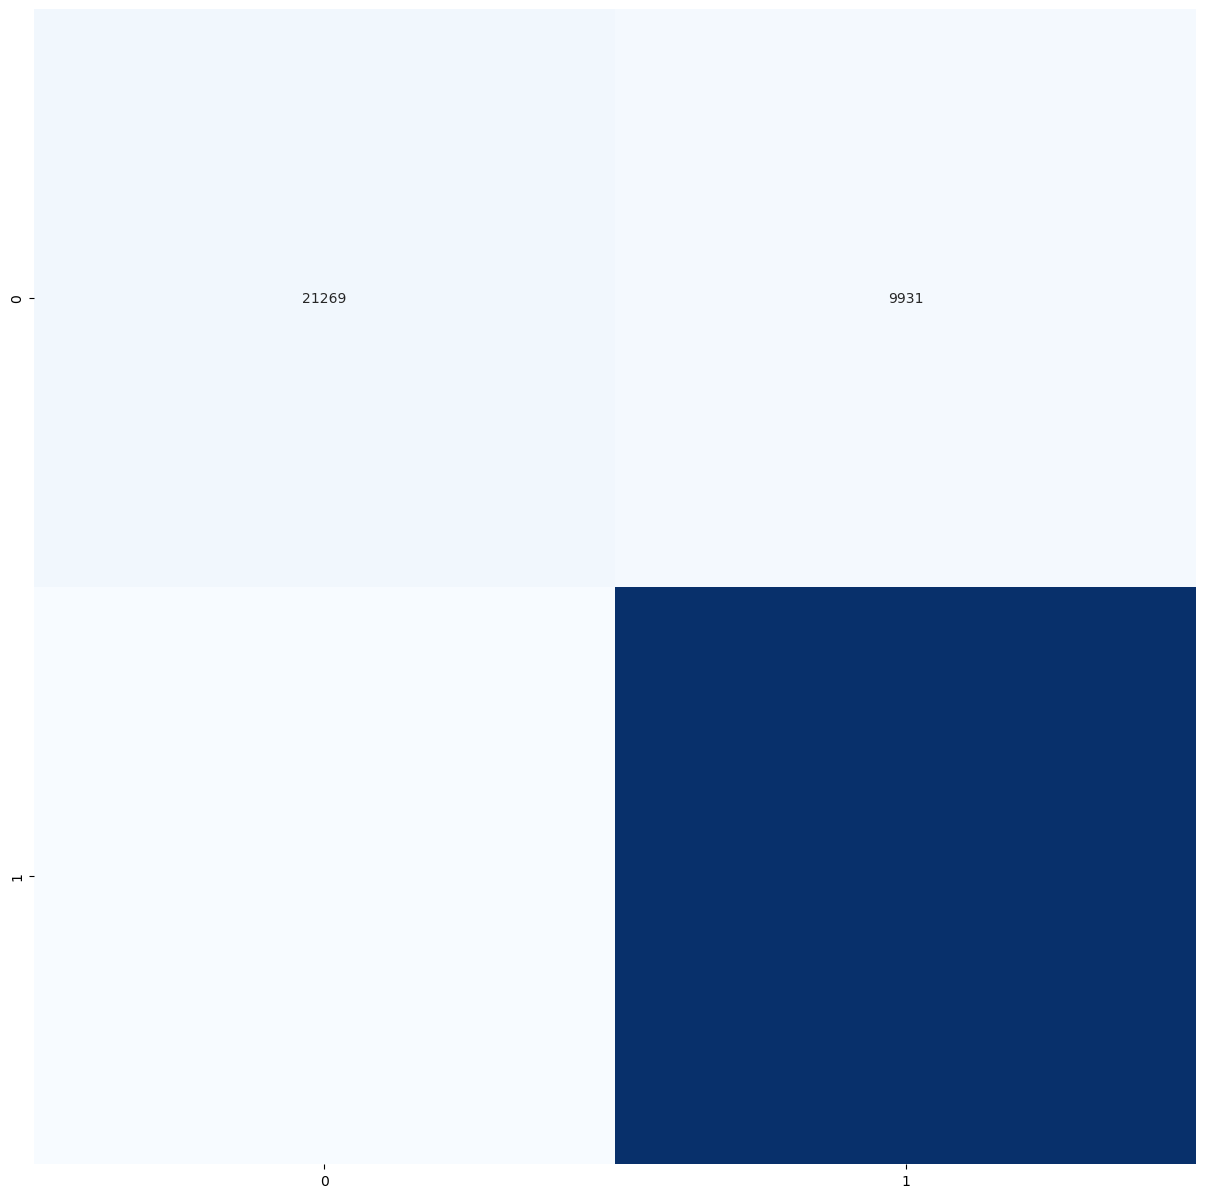

Precision: 0.8598768139702817
Recall: 0.8298974164133739
F1-Score: 0.7783268073410207
Accuracy: 0.8298974164133739
        Actual  Predicted  Correct  sample  simulationRun
20           0          1    False      21              1
21           0          1    False      22              1
22           0          1    False      23              1
23           0          1    False      24              1
24           0          1    False      25              1
...        ...        ...      ...     ...            ...
806395       0          0     True     956             40
806396       0          0     True     957             40
806397       0          0     True     958             40
806398       0          0     True     959             40
806399       0          0     True     960             40

[789600 rows x 5 columns]


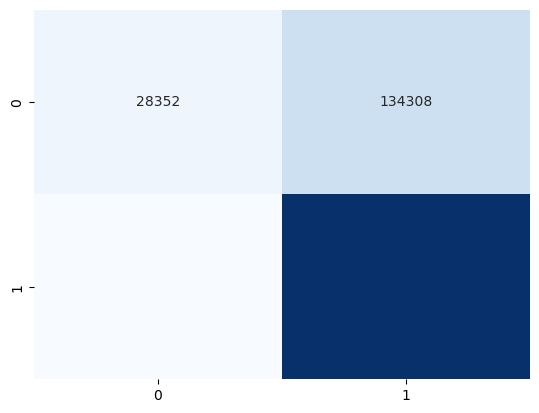

In [21]:
#Results for binary model
predictions = X_new.predict(comb_x_df_test)
results_df = pd.DataFrame({
    'Actual': comb_y_df_test,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})


results_df['sample'] = clean_df_test_cleaned['sample']
results_df['simulationRun'] = clean_df_test_cleaned['simulationRun']

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

accuracy = accuracy_score(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
print(f"Accuracy: {accuracy}")

plt.show()
anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

print(results_df)

Precision: 0.8598768139702817
Recall: 0.8298974164133739
F1-Score: 0.7783268073410207
Accuracy: 0.8298974164133739


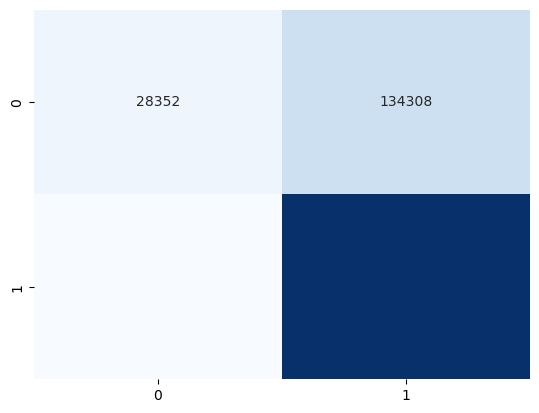

In [22]:
#More results for binary model
results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

In [23]:
filtered_results_df = results_df[results_df['Actual'] == results_df['Predicted']]
filtered_results_df.head()

,Actual,Predicted,Correct,sample,simulationRun
160,1,1,True,161,1
161,1,1,True,162,1
162,1,1,True,163,1
163,1,1,True,164,1
164,1,1,True,165,1


In [41]:
# Get the index from filtered_results_df
filtered_index = filtered_results_df.index

# Filter combined_df_test using the index
filtered_combined_df_test = combined_df_test.loc[filtered_index]
filtered_combined_df_test = filtered_combined_df_test.drop(columns='faultOccurrence')

In [108]:
# Splitting the dataset into train and test sets
train = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\train.csv', on_bad_lines='skip')
cv = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\cv.csv', on_bad_lines='skip')
test = filtered_combined_df_test

tr = train.reset_index()
ts = test.reset_index()
cv_ = cv.reset_index()

# Map fault numbers to a new continuous range
#mapping = {0:0, 1:1, 2:2, 4:3, 5:4, 6:5, 7:6, 8:7, 10:8, 11:9, 12:10, 13:11, 14:12, 16:13, 17:14, 18:15, 19:16, 20:17}
mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 13:13, 14:14, 15:15, 16:16, 17:17, 18:18, 19:19, 20:20}
tr['mappedFaultNumber'] = tr['faultNumber'].map(mapping)
ts['mappedFaultNumber'] = ts['faultNumber'].map(mapping)
cv_['mappedFaultNumber'] = cv_['faultNumber'].map(mapping)
cv_.drop(cv.columns[0], axis=1, inplace=True)
tr.drop(cv.columns[0], axis=1, inplace=True)


In [99]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    
    # Find the index of the column where 'xmeas_1' is located
    start_column_index = df.columns.get_loc('xmeas_1')
    
    # Find the index of the column before the last one
    end_column_index = len(df.columns) - 1
    
    for i in range(0, len(df)-w+1, s):
        # Selecting features from 'xmeas_1' to the column before the last one
        x = np.array(df.iloc[i:i+w, start_column_index:end_column_index])  
        
        # Selecting the target value (mappedFaultNumber) from the last column
        y = df.iloc[i+w-1, -1]  
        
        X.append(x)
        Y.append(y)
        
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def process_data(tr, ts, cv_, SlidingWindow):
    # Initialize window size and step size
    w = 20
    s = 10

    # Initialize lists for storing the data
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    X_cv = []
    Y_cv = []

    # Adjust the loop for the correct number of simulation runs for training, test, and cross-validation sets
    for dataset, max_runs_range in [(tr, range(1, 41)), (ts, range(1, 11)), (cv_, range(41, 61))]:
        for j in range(0, 18):  # Iterating correctly from 0 to 17
            for i in max_runs_range:  # Iterate over the correct number of simulation runs
                df = dataset[(dataset['mappedFaultNumber'] == j) & (dataset['simulationRun'] == i)]
                x_temp, y_temp = SlidingWindow(df, w, s)
                if dataset is tr:
                    X_train.extend(x_temp)
                    Y_train.extend(y_temp)
                elif dataset is ts:
                    X_test.extend(x_temp)
                    Y_test.extend(y_temp)
                else:
                    X_cv.extend(x_temp)
                    Y_cv.extend(y_temp)

    # Convert X and Y to numpy arrays and reshape X for LSTM
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = X_train.reshape(-1, w, X_train.shape[-1])

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_test = X_test.reshape(-1, w, X_test.shape[-1])

    X_cv = np.array(X_cv)
    Y_cv = np.array(Y_cv)
    X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

    return X_train, Y_train, X_test, Y_test, X_cv, Y_cv

# Call the function to process the data
X_train, Y_train, X_test, Y_test, X_cv, Y_cv = process_data(tr, ts, cv_, SlidingWindow)

In [101]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)
print("Shape of X_cv:", X_cv.shape)
print("Shape of Y_cv:", Y_cv.shape)

Shape of X_train: (21935, 20, 52)
Shape of Y_train: (21935,)
Shape of X_test: (13674, 20, 52)
Shape of Y_test: (13674,)
Shape of X_cv: (980, 20, 52)
Shape of Y_cv: (980,)


In [116]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr[tr['faultNumber'] == 0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data.iloc[:, 4:-1]
# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

# Transform the datasets using the fitted StandardScaler
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y_train
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values to one-hot encoded form for train, test, and cross-validation sets
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))
Y_test_enc = enc.transform(Y_test.reshape(-1, 1))
Y_cv_enc = enc.transform(Y_cv.reshape(-1, 1))

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [117]:
def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 52)]          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 256)          185344    
 nal)                                                            
                                                                 
 lstm_15 (LSTM)              (None, 128)               197120    
                                                                 
 dense_13 (Dense)            (None, 300)               38700     
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_14 (Dense)            (None, 18)                5418      
                                                           

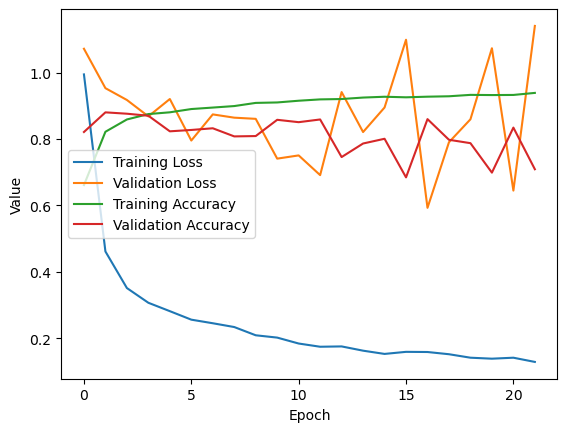

In [118]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 200 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [119]:
# Define your custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '16', '17', '18', '19','20']

# Obtain predictions and true labels
y_pred = enc.inverse_transform(model.predict(X_test_sc, verbose=0))
y_true = enc.inverse_transform(Y_test_enc)

# Generate classification report
report = classification_report(y_true, y_pred, labels=custom_labels)
print("Classification Report:")
print(report)

# Print accuracy score if needed
print("Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score:", accuracy_score(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.65      0.33       335
           1       0.99      1.00      1.00       784
           2       1.00      1.00      1.00       784
           4       0.99      1.00      0.99       786
           5       1.00      1.00      1.00       782
           6       1.00      0.99      1.00       786
           7       1.00      1.00      1.00       786
           8       0.94      0.94      0.94       784
          10       0.99      0.95      0.97       786
          11       0.98      0.98      0.98       786
          12       0.97      0.78      0.87       786
          13       0.98      0.96      0.97       786
          14       1.00      1.00      1.00       784
          16       0.94      0.96      0.95       784
          17       1.00      0.97      0.99       784
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
    

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kamin\miniconda3\e